Imports

In [1]:
import snap
import os
import json
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import itertools

Constants

In [2]:
motif_counts_file = "motif_counts_final.txt"
edge_list_dir = "edgeList"
edge_list_file_type_old  ="_edge_list_no_weight.txt"
edge_list_file_type = edge_list_file_type_old
feature_vector_file = "networkname_features.txt"
labels_file = "ADHD200_CC200_labels.csv"
labels_to_int = {"ADHD-Combined":0, 'ADHD-Inattentive':1, 'ADHD-Hyperactive/Impulsive':2, 'Typically Developing':3}

In [3]:
# load motif_counts a dictionary from file name to 3-node motif counts
motif_counts_json = open(motif_counts_file)
json_str = motif_counts_json.read()
motif_counts = json.loads(json_str)
# print(motif_counts)

In [4]:
# get the labels
labels_df = pd.read_csv(labels_file) 
labels_df = labels_df[['upload_data.network_name','upload_data.subject_pool']]
network_labels = dict([(network,label) for network,label in zip(labels_df['upload_data.network_name'], labels_df['upload_data.subject_pool'])])
# print(network_labels)

In [157]:
def getFeatures(network_to_features):
    # format data & labels
    all_labels = []
    all_binary_labels = [] # 0 if no ADHD, 1 otherwise
    adhd_features = []
    adhd_labels = []
    adhd_no_hyperactive_features = []
    adhd_no_hyperactive_labels = []
    firstFeature = 1
    for network in network_to_features:
        features = network_to_features[network]
        network = network.replace(edge_list_file_type, "")
        label = labels_to_int[network_labels[network]]
        if (firstFeature):
            all_features = features
            firstFeature = 0
        else:
            all_features = np.vstack((all_features, features))
        all_labels.append(label)
        if label != labels_to_int['Typically Developing']:
            all_binary_labels.append(1)
            adhd_features.append(features)
            adhd_labels.append(label)
            if label != labels_to_int['ADHD-Hyperactive/Impulsive']:
                adhd_no_hyperactive_features.append(features)
                adhd_no_hyperactive_labels.append(label)
        else:
            all_binary_labels.append(0)
    return all_features, [0 if i == labels_to_int['Typically Developing'] else 1 for i in all_labels] 


In [184]:
# actual ML
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
def runML(network_to_features):   
    features, labels = getFeatures(network_to_features)
    features_trainOnly, features_test, labels_trainOnly, labels_test = sklearn.model_selection.train_test_split(features, labels, test_size=0.2, stratify=labels)
    print(len(features_trainOnly), len(labels_trainOnly))
    print(len(features_test), len(labels_test))
#     print(labels)
    kfold = sklearn.model_selection.StratifiedKFold(10, True, 1)
    for idx, model in enumerate([MLPClassifier(hidden_layer_sizes=(8, 2),max_iter=2000,tol=0.0001, alpha=0.01, learning_rate='adaptive', solver='adam')]):
        acc_over = []
        acc = []
        for trainIdx, testIdx in kfold.split(features_trainOnly, labels_trainOnly):
            features_train = features_trainOnly[trainIdx]
            features_test =features_trainOnly[testIdx]
            labels_train = np.array(labels_trainOnly)[trainIdx]
            labels_test = np.array(labels_trainOnly)[testIdx]
            model.fit(features_train, labels_train) 
    
            
            labels_predicted = model.predict(features_test)  
            score = sklearn.metrics.accuracy_score(labels_test, labels_predicted)
            acc.append(score)
            print("acc", score)
            
        print("acc", np.mean(acc))
        return model, acc, labels_predicted, features_test, labels_test

In [188]:

model, acc, labels_predicted, features_test, labels_test = runML(network_to_features)

(416, 416)
(104, 104)
MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(8, 2), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
('acc', 0.37209302325581395)
('acc', 0.627906976744186)
('acc', 0.35714285714285715)
('acc', 0.6428571428571429)
('acc', 0.6341463414634146)
('acc', 0.6341463414634146)
('acc', 0.6341463414634146)
('acc', 0.6341463414634146)
('acc', 0.36585365853658536)
('acc', 0.6341463414634146)
('acc', 0.5536585365853659)


In [186]:
labels_predicted = model.predict(features_test)  
print(labels_test)

[0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1
 1 1 0 0]


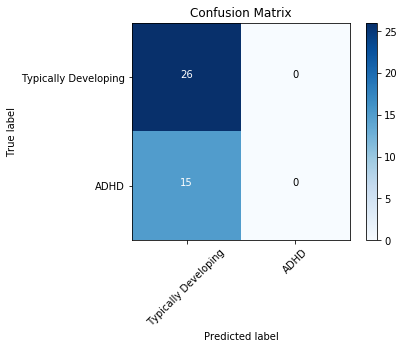

In [187]:
# confusion matrix
plt.figure()
# classes = ["ADHD-Combined", 'ADHD-Inattentive', 'ADHD-Hyperactive/Impulsive', 'Typically Developing']
classes = ['Typically Developing', 'ADHD']
# classes = ["ADHD-Combined", 'ADHD-Inattentive']
cm = sklearn.metrics.confusion_matrix(labels_test, labels_predicted)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2
fmt = 'd'
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [7]:
def getCommunities(CmtyV, numNodes):
    community_matrix = np.zeros((numNodes, numNodes))
    node_calCommunity = {}
    for Cmty in CmtyV:
        for NI in Cmty:
            node_calCommunity[NI] = Cmty
    for i in range(numNodes):
        for j in range(i, numNodes):
            if node_calCommunity[i] == node_calCommunity[j]:
                community_matrix[i][j] = 1 # indicates i and j in same community
    # now just get data points in upper triangular part of matrix as will only get 1s there
    iu1 = np.triu_indices(numNodes)
    return community_matrix[iu1]

In [8]:
def getClusteringCoeff(Graph):
    coeffs = []
    for node in Graph.Nodes():
        coeffs.append(snap.GetNodeClustCf(Graph, node.GetId()))
    return coeffs

In [81]:
# get the features
network_to_features = {}
for filename in os.listdir(edge_list_dir):
    if filename.endswith(edge_list_file_type): 
        Graph = snap.LoadEdgeList(snap.PNGraph, edge_list_dir+"/"+filename, 0, 1)
        UGraph = snap.LoadEdgeList(snap.PUNGraph, edge_list_dir+"/"+filename, 0, 1)
        motifCount_key = filename.replace(edge_list_file_type, edge_list_file_type_old)
        CmtyV = snap.TCnComV()
#         print(network_name)
        feature_vec = list(motif_counts[motifCount_key])
#         feature_vec = []
        DegToCCfV = snap.TFltPrV()
        result = snap.GetClustCfAll(UGraph, DegToCCfV)
#         print(len(result))
        feature_vec.extend(result)
        result = snap.GetBfsEffDiamAll(UGraph, 25, False)
#         print(len(result))
        feature_vec.extend(result)
# ABOVE THIS LINE IS HELPFUL
#         modularity = snap.CommunityCNM(UGraph, CmtyV)
#         feature_vec.extend(modularity)
#         communities = getCommunities(CmtyV, Graph.GetNodes())
#         feature_vec.extend(communities)
        clustering_coeffs = getClusteringCoeff(Graph)
        feature_vec.extend(clustering_coeffs)
        betweenness_centrality = getBetweennessCentrality(Graph)
        feature_vec.extend(betweenness_centrality)
        prank = getPageRank(Graph)
        feature_vec.extend(prank)
        closeness_centrality = getClosenessCentrality(Graph)
        feature_vec.extend(closeness_centrality)
        farness_centrality = getFarnessCentrality(Graph)
        feature_vec.extend(farness_centrality)
        eigen_centrality = getEigenVectorCentrality(UGraph)
        feature_vec.extend(eigen_centrality)
#         if len(feature_vec) != 38585:
#             print(motifCount_key)
#             print(motif_counts[motifCount_key])
#             print(len(motif_counts[motifCount_key]))
# #             print(len(communities))
#             print(len(clustering_coeffs))
#             print(len(betweenness_centrality))
#             print(len(prank))
#             print(len(closeness_centrality))
#             print(len(farness_centrality))
#             print(len(eigen_centrality))
#             print(len(feature_vec))
        network_to_features[filename] = np.array(feature_vec)
        print(network_to_features[filename].shape)

(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)
(1160,)


In [9]:
def getBetweennessCentrality(Graph):
    centrality = []
    Nodes = snap.TIntFltH()
    Edges = snap.TIntPrFltH()
    snap.GetBetweennessCentr(Graph, Nodes, Edges, 1.0, True)
    nodeid_centrality = {}
    for node in Nodes:
        nodeid_centrality[node] = Nodes[node]
    for node_id in sorted(nodeid_centrality):
        centrality.append(nodeid_centrality[node_id])
    return centrality

In [10]:
def getPageRank(Graph):
    nodeid_prank = {}
    prank = []
    PRankH = snap.TIntFltH()
    snap.GetPageRank(Graph, PRankH)
    for node in PRankH:
        nodeid_prank[node] = PRankH[node]
    for node_id in sorted(nodeid_prank):
        prank.append(nodeid_prank[node_id])
    return prank

In [11]:
def getClosenessCentrality(Graph):
    coeffs = []
    for node in Graph.Nodes():
        coeffs.append(snap.GetClosenessCentr(Graph, node.GetId()))
    return coeffs

In [12]:
def getFarnessCentrality(Graph):
    coeffs = []
    for node in Graph.Nodes():
        coeffs.append(snap.GetFarnessCentr(Graph, node.GetId()))
    return coeffs

In [13]:
def getEigenVectorCentrality(Graph):
    centrality = []
    NIdEigenH = snap.TIntFltH()
    snap.GetEigenVectorCentr(Graph, NIdEigenH)
    nodeid_centrality = {}
    for node in NIdEigenH:
        nodeid_centrality[node] = NIdEigenH[node]
    for node_id in sorted(nodeid_centrality):
        centrality.append(nodeid_centrality[node_id])
    return centrality